In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),
        nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size = 3, padding = 1))
    

In [7]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super().__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim = 1)
        return X

In [14]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
assert Y.shape == (4, 23, 8, 8)
Y.shape

torch.Size([4, 23, 8, 8])

In [18]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),
        nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size = 1),
        nn.AvgPool2d(kernel_size = 2, stride = 2))

In [20]:
blk = transition_block(23, 10)
assert blk(Y).shape == (4, 10, 4, 4)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [21]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

In [22]:
num_channels, growth_rate = 64, 32
num_convs_in_dense_block = [4, 4, 4, 4]

blks = []
for i, num_convs in enumerate(num_convs_in_dense_block):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate

    if i != len(num_convs_in_dense_block) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [24]:
net = nn.Sequential(b1, *blks, nn.BatchNorm2d(num_channels),
                    nn.ReLU(),
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(),
                    nn.Linear(num_channels, 10))

loss 0.237, train acc 0.919, test acc 0.888
1467.1 examples/sec on cuda:0


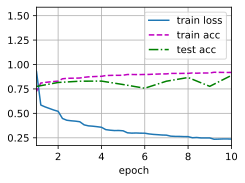

In [26]:
from matplotlib_inline.backend_inline import set_matplotlib_formats

def use_svg_display():
    set_matplotlib_formats('svg')

d2l.use_svg_display = use_svg_display

lr, num_epochs, batch_size = 0.01, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())